In [1]:
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import os
import random
from collections import Counter, defaultdict
from itertools import product, combinations
import math
import cv2
from sklearn.model_selection import train_test_split

random.seed(42)

%matplotlib inline

In [2]:
import keras
from keras.layers import Input, Conv2D, Lambda, average, Dense, Flatten,MaxPooling2D, BatchNormalization, Dropout, Activation, Subtract, subtract
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import numpy.random as rng

/home/anurag/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
IMAGE_SIZE = (70, 70)

def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
 
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
 
	# return the edged image
	return edged

def process_image(image_location):
    """
        Given the image location, process the image
    """
    # print(image_location)
    
    image = cv2.imread(image_location)
    
    if image.shape[0] != IMAGE_SIZE[0] or image.shape[1] != IMAGE_SIZE[1]:
        # print("Resizing the image: {0}".format(image_location))
        resized_image = cv2.resize(image, IMAGE_SIZE, interpolation = cv2.INTER_AREA)
    else:
        resized_image = image
    
    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    
    # get the edges from the image
    edges = auto_canny(gray)
    #print(edges.shape)
    
    
    # assert(denoised != edges)
    # add the two images in a weighted manner
    weighted_sum = cv2.addWeighted(gray, 0.8, edges, 0.2, 0)
       
    return gray

In [4]:
type_locations = {"b": ["bb", "wb"], "n": ["bn", "wn"], "k": ["bk", "wk"], "p": ["bp", "wp"], "q": ["bq", "wq"], "r": ["br", "wr"]}
type_name_to_label = { "p":0, "b":1, "n":2, "r":3, "q": 4, "k":5 }

## The below cell need to be replaced with the location of the new data

In [6]:
def get_features_labels(data_path):
    X, y = [], []
    features_with_labels = []
    
    for type_name in type_locations:
        for folder_name in type_locations[type_name]:
            piece_type_folder = os.path.join(data_path, folder_name)
            for f in (os.listdir(piece_type_folder)):
                if f.endswith(".jpg"): 
                    

                    img_file_loc = os.path.join(piece_type_folder, f)
                    #print(img_file_loc)
                    grayscale_image = process_image(img_file_loc)
                    actual_image = grayscale_image
                    grayscale_image = grayscale_image[..., np.newaxis]
                    label = type_name_to_label[type_name]
                    features_with_labels.append({"feature": grayscale_image, "label": label, "image": actual_image})   
                    
    random.shuffle(features_with_labels)
    #print(X[0][0])
    #print(X[0][1])
    X = [x["feature"] for x in features_with_labels]
    y = [x["label"] for x in features_with_labels]
    images = [x["image"] for x in features_with_labels]
    
    X = np.array(X)
    X = X.astype('float32')
    X /= 255

    return X, np.array(y), images

In [7]:
X_train, y_train, _ = get_features_labels("/home/anurag/AR/data/23March/train")
X_test, y_test, test_images = get_features_labels("/home/anurag/AR/data/23March/test")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5838, 70, 70, 1)
(5838,)
(291, 70, 70, 1)
(291,)


In [8]:
# batch size
batch_size = 64


# number of training epochs
epochs = 150

required_input_shape = (*IMAGE_SIZE, 1)

In [8]:
model_folder_name = "fine_tune/models"
tensorboard_logs_folder_location = "fine_tune/logs"

In [9]:
def load_6_class_cnn_model(model_weights_location):
    """"""
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='valid', input_shape=required_input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.5))

    model.add(Flatten())
    
    model.add(Dense(2048))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.6))
    
    model.add(Dense(6))
    model.add(Activation('softmax'))
    model.summary()

    # load the model weights
    model.load_weights(model_weights_location)
                           
    adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

In [10]:
trained_model = load_6_class_cnn_model("/home/anurag/AR/Extending-Board-Games-using-deep-learning/API/models/6_class_cnn.hdf5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 68, 68, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 68, 68, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 68, 68, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
__________

In [12]:
# checkpoint
if not os.path.exists(model_folder_name):
    os.makedirs(model_folder_name)

# tensorboard logs
if not os.path.exists(tensorboard_logs_folder_location):
    os.makedirs(tensorboard_logs_folder_location)

filepath = os.path.join(model_folder_name, "6_class_cnn_fine_tuned.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=20, verbose=1, mode='max')

tensorboard = TensorBoard(log_dir=tensorboard_logs_folder_location, histogram_freq=0, write_graph=True, write_images=True)

callbacks_list = [checkpoint, earlystop, tensorboard]

adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
trained_model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

hist = trained_model.fit(X_train, y_train, shuffle=True, batch_size=batch_size,
                 epochs=epochs, verbose=1,
                 validation_data=(X_test, y_test), callbacks=callbacks_list)

# Evaluating the model on the test data
score, accuracy = trained_model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Train on 4774 samples, validate on 60 samples
Epoch 1/150
4774/4774 [==============================] - 4s 736us/step - loss: 3.0724 - acc: 0.1850 - val_loss: 2.0603 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to fine_tune/models\6_class_cnn_fine_tuned.hdf5
Epoch 2/150
4774/4774 [==============================] - 2s 363us/step - loss: 2.4861 - acc: 0.2220 - val_loss: 1.7797 - val_acc: 0.3500

Epoch 00002: val_acc improved from 0.33333 to 0.35000, saving model to fine_tune/models\6_class_cnn_fine_tuned.hdf5
Epoch 3/150
4774/4774 [==============================] - 2s 363us/step - loss: 2.1722 - acc: 0.2694 - val_loss: 1.5848 - val_acc: 0.4167

Epoch 00003: val_acc improved from 0.35000 to 0.41667, saving model to fine_tune/models\6_class_cnn_fine_tuned.hdf5
Epoch 4/150
4774/4774 [==============================] - 2s 363us/step - loss: 1.9598 - acc: 0.3238 - val_loss: 1.4726 - val_acc: 0.4167

Epoch 00004: val_acc did not improve from 0.41667
Epoch 5

4774/4774 [==============================] - 2s 362us/step - loss: 0.2813 - acc: 0.9118 - val_loss: 0.2210 - val_acc: 0.9333

Epoch 00078: val_acc did not improve from 0.93333
Epoch 79/150
4774/4774 [==============================] - 2s 364us/step - loss: 0.2661 - acc: 0.9154 - val_loss: 0.2119 - val_acc: 0.9333

Epoch 00079: val_acc did not improve from 0.93333
Epoch 80/150
4774/4774 [==============================] - 2s 362us/step - loss: 0.2641 - acc: 0.9160 - val_loss: 0.2143 - val_acc: 0.9333

Epoch 00080: val_acc did not improve from 0.93333
Epoch 81/150
4774/4774 [==============================] - 2s 363us/step - loss: 0.2756 - acc: 0.9093 - val_loss: 0.2012 - val_acc: 0.9500

Epoch 00081: val_acc improved from 0.93333 to 0.95000, saving model to fine_tune/models\6_class_cnn_fine_tuned.hdf5
Epoch 82/150
4774/4774 [==============================] - 2s 366us/step - loss: 0.2574 - acc: 0.9177 - val_loss: 0.1959 - val_acc: 0.9500

Epoch 00082: val_acc did not improve from 0.95000
Ep

In [11]:
## Helper method to print a confusion matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    
import matplotlib
matplotlib.rcParams['figure.figsize'] = [100, 15]

IMAGES_PER_ROW = 5

def plot_mispredicted_images(images, actual_values, predicted_values, mapping_func = None):
    print(actual_values)
    mis_predictions = actual_values ^ predicted_values
    mis_prediction_indices = np.nonzero(mis_predictions)[0]
    print(mis_prediction_indices)
    
    num_failed_images = len(mis_prediction_indices)
    
    if num_failed_images == 0:
        print("All images predicted correctly.")
        return
        
    
    if num_failed_images == 1:
        print("{0} mispredicted as {1}".format(actual_values[mis_prediction_indices[0]], predicted_values[mis_prediction_indices[0]]))
        plt.imshow(images[mis_prediction_indices[0]], cmap='gray')
        return
    elif num_failed_images < IMAGES_PER_ROW:
        num_images_per_row = 2
    else:
        num_images_per_row = IMAGES_PER_ROW
        
    num_rows = (num_failed_images // num_images_per_row) + int((num_failed_images % num_images_per_row) != 0)
    if num_rows == 1:
        num_rows = 2

    print("Number of failed images: " + str(num_failed_images))
    print("Num rows: {0}. Num images/row: {1}".format(num_rows, num_images_per_row))
    #print(num_rows)
    #print(num_images_per_row)


    fig, axes = plt.subplots(num_rows, num_images_per_row)

    current_image_idx = 0

    for itr in range(num_rows):
        #print(itr)
        for jtr in range(num_images_per_row):
            if current_image_idx == num_failed_images:
                break
            
            print("{0}, {1}, {2}".format(itr, jtr, current_image_idx))
            axes[itr, jtr].imshow(images[mis_prediction_indices[current_image_idx]], cmap='gray')
            if mapping_func:
                axes[itr, jtr].set_title("{0} predicted as {1}".format(mapping_func(actual_values[mis_prediction_indices[current_image_idx]]), mapping_func(predicted_values[mis_prediction_indices[current_image_idx]])))
            else:
                axes[itr, jtr].set_title("{0} predicted as {1}".format(actual_values[mis_prediction_indices[current_image_idx]], predicted_values[mis_prediction_indices[current_image_idx]]))
            #print(current_image_idx)
            current_image_idx += 1

## Check predictions using the best trained model

In [11]:
X_test, y_test, test_images = get_features_labels("/home/anurag/AR/sriraj_v2/test_v2")
y_test

/home/anurag/AR/sriraj_v2/test_v2/bb/b1_e_6.jpg
/home/anurag/AR/sriraj_v2/test_v2/bb/b11_d_5.jpg
/home/anurag/AR/sriraj_v2/test_v2/bb/b5_g_7.jpg
/home/anurag/AR/sriraj_v2/test_v2/bb/b6_e_6.jpg
/home/anurag/AR/sriraj_v2/test_v2/bb/b13_f_7.jpg
/home/anurag/AR/sriraj_v2/test_v2/bb/b15_g_5.jpg
/home/anurag/AR/sriraj_v2/test_v2/bb/b11_f_6.jpg
/home/anurag/AR/sriraj_v2/test_v2/bb/b10_f_6.jpg
/home/anurag/AR/sriraj_v2/test_v2/bb/b7_e_6.jpg
/home/anurag/AR/sriraj_v2/test_v2/bb/b5_e_6.jpg
/home/anurag/AR/sriraj_v2/test_v2/bb/b14_d_5.jpg
/home/anurag/AR/sriraj_v2/test_v2/bb/b3_g_7.jpg
/home/anurag/AR/sriraj_v2/test_v2/bb/b13_g_5.jpg
/home/anurag/AR/sriraj_v2/test_v2/bb/b2_e_6.jpg
/home/anurag/AR/sriraj_v2/test_v2/bb/b4_e_6.jpg
/home/anurag/AR/sriraj_v2/test_v2/bb/b10_d_5.jpg
/home/anurag/AR/sriraj_v2/test_v2/bb/b9_f_6.jpg
/home/anurag/AR/sriraj_v2/test_v2/bb/b8_e_6.jpg
/home/anurag/AR/sriraj_v2/test_v2/bb/b12_g_5.jpg
/home/anurag/AR/sriraj_v2/test_v2/bb/b9_d_5.jpg
/home/anurag/AR/sriraj_v2/test_

/home/anurag/AR/sriraj_v2/test_v2/wp/b6_e_2.jpg
/home/anurag/AR/sriraj_v2/test_v2/wp/b6_f_2.jpg
/home/anurag/AR/sriraj_v2/test_v2/wp/b7_e_2.jpg
/home/anurag/AR/sriraj_v2/test_v2/wp/b1_e_2.jpg
/home/anurag/AR/sriraj_v2/test_v2/wp/b12_f_2.jpg
/home/anurag/AR/sriraj_v2/test_v2/wp/b1_f_2.jpg
/home/anurag/AR/sriraj_v2/test_v2/wp/b11_f_2.jpg
/home/anurag/AR/sriraj_v2/test_v2/wp/b8_f_2.jpg
/home/anurag/AR/sriraj_v2/test_v2/wp/b2_f_2.jpg
/home/anurag/AR/sriraj_v2/test_v2/wp/b14_f_2.jpg
/home/anurag/AR/sriraj_v2/test_v2/wp/b3_f_2.jpg
/home/anurag/AR/sriraj_v2/test_v2/wp/b3_e_2.jpg
/home/anurag/AR/sriraj_v2/test_v2/wp/b10_e_2.jpg
/home/anurag/AR/sriraj_v2/test_v2/wp/b15_f_2.jpg
/home/anurag/AR/sriraj_v2/test_v2/wp/b5_f_2.jpg
/home/anurag/AR/sriraj_v2/test_v2/wp/b7_f_2.jpg
/home/anurag/AR/sriraj_v2/test_v2/wp/b4_e_2.jpg
/home/anurag/AR/sriraj_v2/test_v2/bq/b1_d_8.jpg
/home/anurag/AR/sriraj_v2/test_v2/bq/b15_e_3.jpg
/home/anurag/AR/sriraj_v2/test_v2/bq/b9_e_4.jpg
/home/anurag/AR/sriraj_v2/test_v2/

array([5, 1, 0, 1, 3, 1, 0, 3, 5, 2, 4, 0, 1, 4, 0, 3, 0, 4, 5, 1, 1, 2,
       0, 1, 2, 5, 3, 1, 5, 1, 4, 5, 4, 2, 2, 2, 4, 2, 3, 3, 0, 3, 3, 4,
       1, 3, 5, 2, 3, 4, 3, 3, 4, 4, 5, 2, 1, 4, 5, 1, 3, 0, 0, 2, 3, 3,
       1, 0, 2, 2, 3, 3, 1, 1, 4, 0, 2, 2, 3, 1, 3, 3, 0, 1, 0, 0, 1, 0,
       2, 0, 1, 3, 4, 4, 3, 1, 2, 2, 1, 5, 4, 2, 0, 0, 4, 5, 3, 3, 0, 2,
       2, 0, 0, 2, 5, 0, 1, 3, 5, 1, 2, 2, 1, 0, 2, 2, 3, 2, 3, 1, 2, 0,
       3, 3, 5, 1, 5, 0, 3, 3, 4, 1, 3, 3, 3, 4, 2, 2, 1, 0, 4, 3, 1, 3,
       1, 0, 5, 4, 5, 5, 2, 1, 0, 0, 3, 2, 1, 3, 3, 3, 1, 0, 2, 1, 1, 2,
       2, 2, 2, 2, 0, 2, 3, 5, 3, 2, 0, 2, 3, 2, 0, 2, 2, 2, 4, 2, 2, 3,
       0, 3, 3, 4, 2, 5, 2, 5, 1, 4, 1, 1, 2, 0, 0, 2, 0, 3, 5, 0, 0, 1,
       4, 3, 4, 0, 5, 1, 0, 5, 2, 0, 5, 3, 1, 3, 5, 1, 0, 3, 1, 5, 1, 3,
       1, 2, 4, 1, 3, 1, 5, 2, 0, 4, 1, 0, 4, 0, 4, 0, 1, 3, 1, 3, 2, 1,
       1, 2, 0, 1, 5, 3, 0, 3, 1, 2, 3, 1, 2, 1, 2, 2, 1, 1, 3, 1, 1, 0,
       4, 0, 5, 2, 3])

In [12]:
# Evaluating the model on the test data
score, accuracy = trained_model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 4.2773388960107495
Test accuracy: 0.1958762887622073


Confusion matrix, without normalization
[[16  2  0 28  0  5]
 [37  1  0 16  0  6]
 [28  2  0 29  1  0]
 [22  0  1 32  3  2]
 [ 9  3  0 17  0  1]
 [14  0  1  7  0  8]]
0.1958762886597938


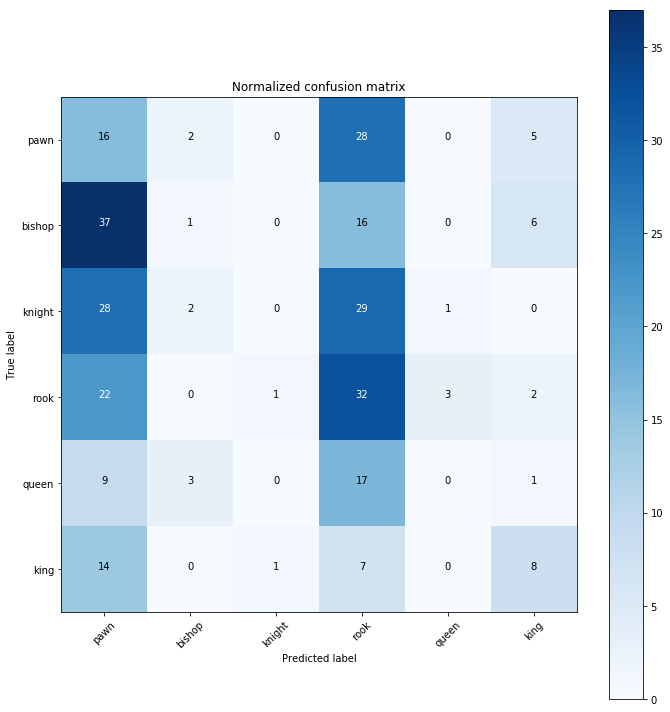

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score
plt.rcParams["figure.figsize"] = (10,10)
class_names = ["pawn", "bishop", "knight", "rook", "queen", "king"]

#trained_model_path = "/home/anurag/AR/trained_models/23Mar/6_class_cnn_fine_tuned.hdf5"
#trained_model = load_6_class_cnn_model(trained_model_path)

# trained_model.load_weights(filepath)

test_predictions = trained_model.predict(X_test, batch_size=batch_size)
y_test_pred = [np.argmax(x) for x in test_predictions]
cnf_matrix = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,title='Normalized confusion matrix')
print(accuracy_score(y_test, y_test_pred))

In [14]:
base_location = "/home/anurag/AR/analysis_results/29Mar2"
def save_mispredicted_images(images, actual_values, predicted_values, mapping_func = None):
    # print(actual_values)
    mis_predictions = actual_values ^ predicted_values
    mis_prediction_indices = np.nonzero(mis_predictions)[0]
    print(mis_prediction_indices)
    
    num_failed_images = len(mis_prediction_indices)
    
    if num_failed_images == 0:
        print("All images predicted correctly.")
        return
        
    
    if num_failed_images == 1:
        print("{0} mispredicted as {1}".format(actual_values[mis_prediction_indices[0]], predicted_values[mis_prediction_indices[0]]))
        plt.imshow(images[mis_prediction_indices[0]], cmap='gray')
        return
    elif num_failed_images < IMAGES_PER_ROW:
        num_images_per_row = 2
    else:
        num_images_per_row = IMAGES_PER_ROW
        
    num_rows = (num_failed_images // num_images_per_row) + int((num_failed_images % num_images_per_row) != 0)
    if num_rows == 1:
        num_rows = 2

    print("Number of failed images: " + str(num_failed_images))
    print("Num rows: {0}. Num images/row: {1}".format(num_rows, num_images_per_row))
    #print(num_rows)
    #print(num_images_per_row)


    # fig, axes = plt.subplots(num_rows, num_images_per_row)

    current_image_idx = 0

    for itr in range(num_rows):
        #print(itr)
        for jtr in range(num_images_per_row):
            if current_image_idx == num_failed_images:
                break
            
            # print("{0}, {1}, {2}".format(itr, jtr, current_image_idx))
            
            # axes[itr, jtr].imshow(images[mis_prediction_indices[current_image_idx]], cmap='gray')
            if mapping_func:
                image_location = os.path.join(base_location, str(current_image_idx) + "_" + "{0}_as_{1}.jpg".format(mapping_func(actual_values[mis_prediction_indices[current_image_idx]]), mapping_func(predicted_values[mis_prediction_indices[current_image_idx]])))
                cv2.imwrite(image_location, images[mis_prediction_indices[current_image_idx]])
    
            else:
                image_location = os.path.join(base_location, str(current_image_idx) + "_" + "{0}_as_{1}.jpg".format(actual_values[mis_prediction_indices[current_image_idx]], predicted_values[mis_prediction_indices[current_image_idx]]))
                cv2.imwrite(image_location, images[mis_prediction_indices[current_image_idx]])
            #print(current_image_idx)
            current_image_idx += 1    

In [17]:
# test_images = np.squeeze(X_test)
reverse_label_mappings = {type_name_to_label[y]: y for y in type_name_to_label}
print(reverse_label_mappings)
save_mispredicted_images(test_images, y_test, y_test_pred, lambda x: reverse_label_mappings[x])
# plot_mispredicted_images(test_images, y_test, y_test_pred, lambda x: reverse_label_mappings[x])

{0: 'p', 1: 'b', 2: 'n', 3: 'r', 4: 'q', 5: 'k'}
[  0   1   2   3   5   6   8   9  10  15  16  17  18  20  21  23  24  25
  26  28  30  31  33  34  35  36  37  39  40  44  45  46  47  48  49  52
  53  54  58  59  60  61  63  66  68  69  71  73  75  76  77  79  80  81
  83  86  87  88  89  90  91  92  93  94  95  96  97  99 100 101 102 104
 105 106 108 109 110 112 113 114 116 119 120 121 122 123 124 126 127 129
 131 132 133 134 136 138 139 140 141 142 144 145 147 148 149 150 151 152
 155 156 157 158 159 160 161 162 163 164 165 166 167 170 172 175 176 177
 178 179 181 182 183 184 185 186 187 191 192 193 196 197 201 202 203 204
 205 208 209 210 211 213 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 231 233 234 235 237 238 240 242 243 244 245 246 247 248 249
 252 253 254 255 257 258 260 262 263 265 266 267 268 270 271 272 273 276
 277 278 279 280 281 282 283 284 285 286 287 288 290]
Number of failed images: 211
Num rows: 43. Num images/row: 5
